# Dynamic mode decomposition with control on a high-dimensional, linear system sparse in the Fourier space
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We illustrate DMDc for system identification on a high-dimensional, linear system,
which intrinsic dynamics are low-dimensional in the Fourier space
(this is example 3 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$x_{k+1} =Ax_k + B u_k,\quad y_k = x_k$$

The sparse dynamical system is constructed in a two-dimensional Fourier domain.
Five spatial modes are allowed to be nonzero.
The boundary conditions are periodic restricting the dynamics to a torus.

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.gridspec import GridSpec
from scipy import signal

import pykoopman as pk

Import torus example from the pyKoopman package.
This high-dimensional, linear system is characterized with few, active frequency components.
We further set parameters for the time discretization and use the default parameters
for the system.

In [2]:
np.random.seed(1) # for reproducibility
from pykoopman.common import torus_dynamics

show_movie = 0
T = 4          # integration time
dt = 0.01      # time step
n_samples = int(T/dt)

torus = torus_dynamics()
n_states = torus.n_states
print('Damping coefficients: ', torus.damping)
print('Frequencies: ', torus.frequencies)
print('Initial values: ',torus.IC)

Damping coefficients:  [-0.06704675 -0.04173048 -0.05586898 -0.01403869 -0.01981015]
Frequencies:  [1.29490465 1.65555972 0.90432793 1.87415841 0.33098395]
Initial values:  [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]


The dynamical parameters are set.
Create control matrix as a single point actuator in physical space
and visualize the actuator/control matrix in physical and Fourier space.

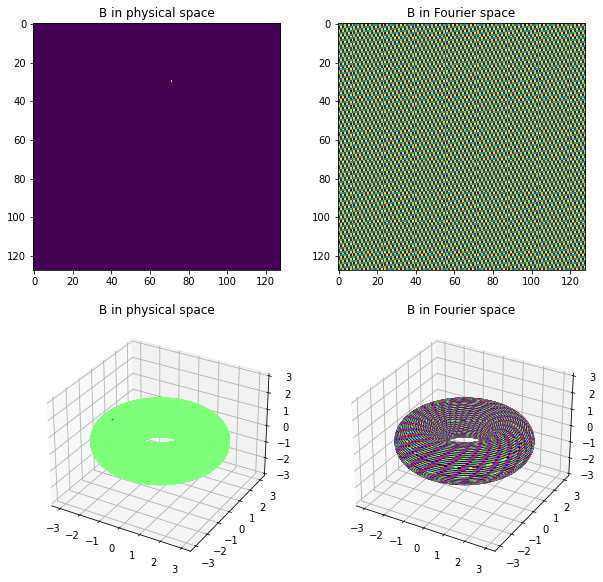

In [3]:
torus.set_point_actuator()

Bhat = torus.Bhat
B = torus.B

# as matrix
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')
ax2 = plt.subplot2grid((2,2),(0,1), title='B in Fourier space')
ax2.imshow(np.real(Bhat),interpolation='none', aspect='equal')

# on torus
ax3 = plt.subplot2grid((2,2),(1,0), title='B in physical space', projection='3d')
surface = torus.viz_torus(ax3, B)
ax4 = plt.subplot2grid((2,2),(1,1), title='B in Fourier space', projection='3d')
surface = torus.viz_torus(ax4, Bhat.real)

Generate random control sequence and integrate open-loop system to collect
high-dimensional data, for which the underlying low-dimensional dynamics are governed by the above Fourier components.
We also evolve the unforced dynamics for reference.

Evolving continuous-time dynamics without control.
Evolving discrete-time dynamics with or without control.


[Text(0, 0.5, 'u'), Text(0.5, 0, 'Time index')]

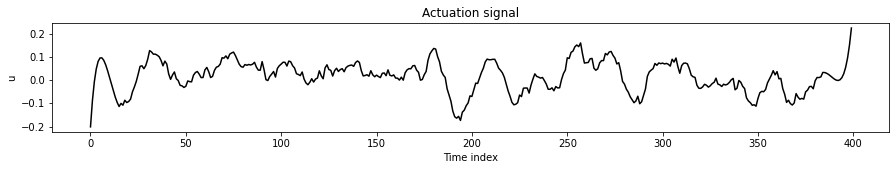

In [4]:
# Random control inputs
U = 0.2*np.random.randn(n_samples)
U = signal.savgol_filter(U, 31, 4)
# U = 0.0001*np.sin(2*np.pi*10*torus.time_vector)

torus.advance(n_samples, dt) # unforced dynamics
Xhat_ct = torus.Xhat
X_unforced = torus.X

# Note the following is overwriting X, Xhat in torus object
torus.advance_discrete_time(n_samples, dt, U) # forced dynamics
Xhat_dt = torus.Xhat

# Show actuation signal
fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(111, title = 'Actuation signal')
ax.plot(U,'-', color='black')
ax.set(ylabel=r'u', xlabel='Time index')

Show a realization of the unforced and forced system.

[Text(0, 0.5, 'xi'), Text(0.5, 0, 'Time')]

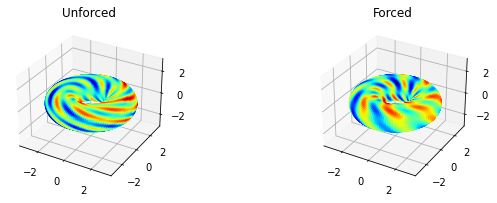

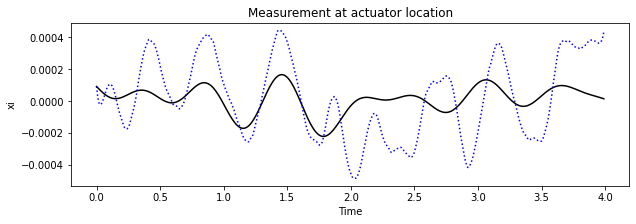

In [5]:
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot2grid((1,2),(0,0), title='Unforced', projection='3d')
torus.viz_torus(ax1,X_unforced[:,125].reshape(torus.n_states,torus.n_states))

ax2 = plt.subplot2grid((1,2),(0,1), title='Forced', projection='3d')
torus.viz_torus(ax2,torus.X[:,125].reshape(torus.n_states,torus.n_states))

fig = plt.figure(figsize=(10,3))
ax3 = plt.subplot2grid((1,1),(0,0), title='Measurement at actuator location')
measure_at_actuator_location = np.where(torus.B.reshape(n_states**2)!=0)[0]
ax3.plot(torus.time_vector, np.squeeze(X_unforced[measure_at_actuator_location,:]),'-', color='black')
ax3.plot(torus.time_vector, np.squeeze(torus.X[measure_at_actuator_location,:]),':', color='blue')
ax3.set(ylabel=r'xi', xlabel='Time')

Show underlying Fourier components and their time evolution.

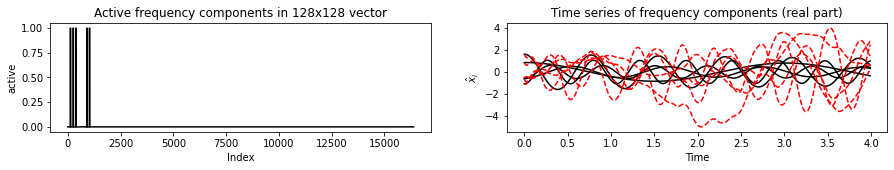

In [6]:
n_states = torus.n_states
xhat_ct = Xhat_ct[torus.mask.reshape(n_states**2)==1,:]
xhat_dt = Xhat_dt[torus.mask.reshape(n_states**2)==1,:]

fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(121, title = 'Active frequency components in 128x128 vector')
ax.plot(torus.mask.reshape(n_states**2),'-', color='black')
ax.set(ylabel=r'active', xlabel='Index')

ax = fig.add_subplot(122, title = 'Time series of frequency components (real part)')
ax.plot(torus.time_vector,np.real(xhat_ct.T),'-', color='black', label='no control')
ax.set(ylabel=r'$\hat{x}_i$', xlabel='Time')
ax.plot(torus.time_vector,np.real(xhat_dt.T),'--', color='red', label='with control')

Visualize true Fourier modes, that characterize the system.
Modes are sorted according to spatial frequency.

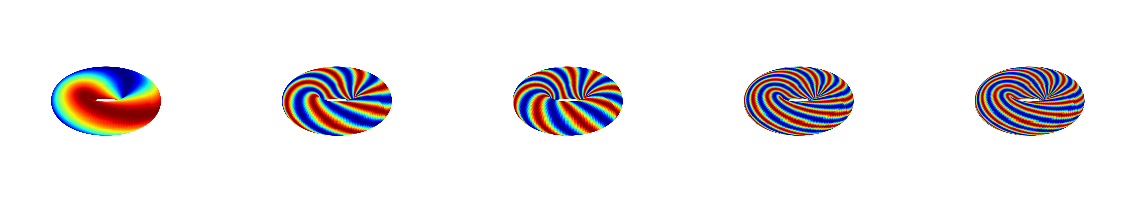

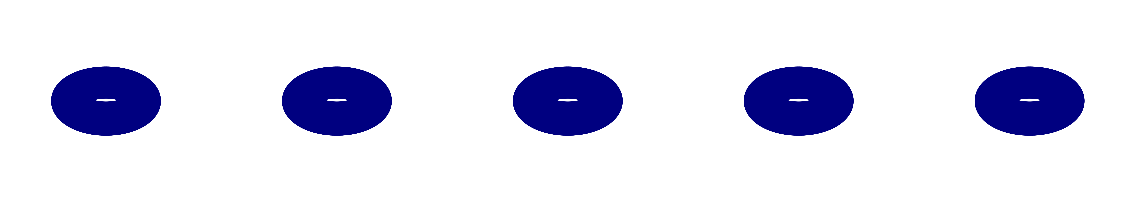

In [7]:
PhiTrue = torus.modes
sorting_index = np.argsort(torus.J[:,0]+torus.J[:,1])
torus.viz_all_modes(np.real(PhiTrue[:,sorting_index]))
torus.viz_all_modes(np.imag(PhiTrue[:,sorting_index]))

Apply DMD (without control) to the dataset and visualize the resulting modes,
which are not accurately recovered.

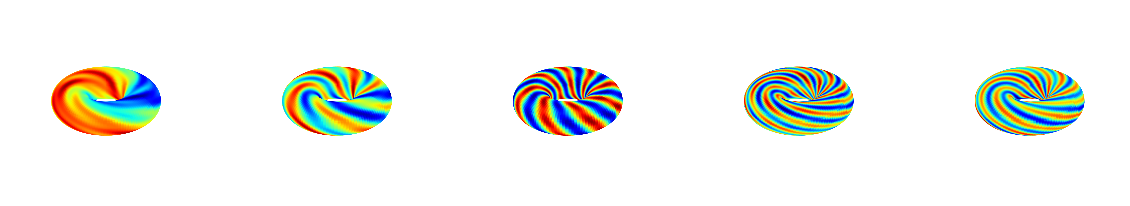

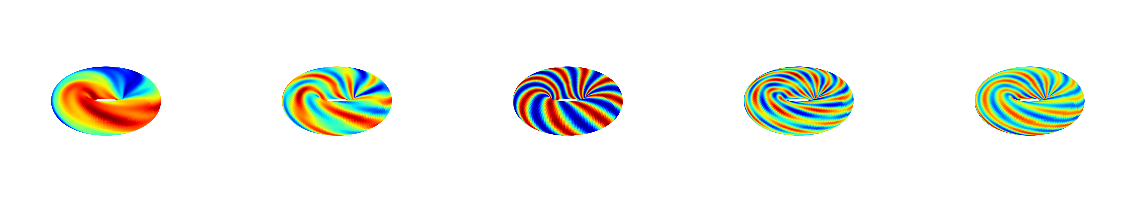

In [8]:
from pydmd import DMD
dmd = DMD(svd_rank=10)
model_dmd = pk.Koopman(regressor=dmd)
model_dmd.fit(torus.X.T)

Phi = model_dmd.regressor.regressor.modes
# modes#regressor.regressor.modes
torus.viz_all_modes(np.real(Phi[:,::2]))
torus.viz_all_modes(np.imag(Phi[:,::2])) # every other mode as they come in pairs

Apply DMDc to the dataset and visualize resulting modes,
which are accurately recovered.

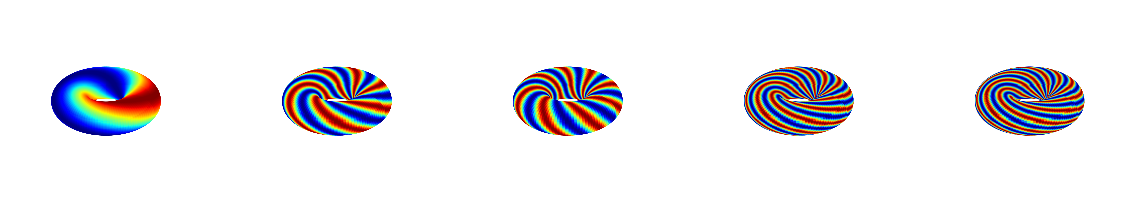

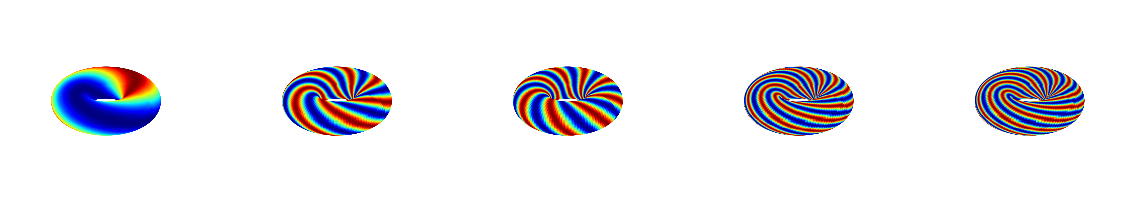

In [9]:
DMDc = pk.regression.DMDc(svd_rank=11, svd_output_rank=10)

model = pk.Koopman(regressor=DMDc)
model.fit(torus.X.T,U[:,np.newaxis],dt)

Phi_dmdc = model.modes
torus.viz_all_modes(np.real(Phi_dmdc[:,::2]))
torus.viz_all_modes(np.imag(Phi_dmdc[:,::2]))

Compare the control matrix identified using DMDc with the true control matrix.
Note that the "effective control matrix" must be used for comparison (not the single point actuator),
as the underlying sparse dynamics only consider the control term for the 5 active modes;
other modes are neglected.

True

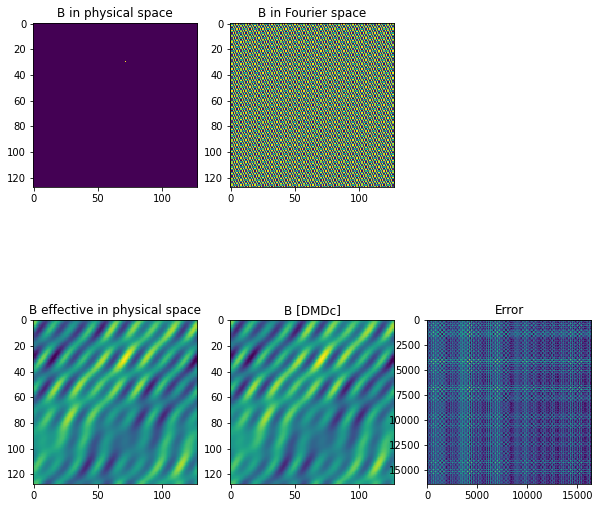

In [10]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,3),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')

ax2 = plt.subplot2grid((2,3),(0,1), title='B in Fourier space')
ax2.imshow(np.real(Bhat),interpolation='none', aspect='equal')

ax3 = plt.subplot2grid((2,3),(1,0), title='B effective in physical space')
ax3.imshow(np.real(torus.B_effective),interpolation='none', aspect='equal')

ax4 = plt.subplot2grid((2,3),(1,1), title='B [DMDc]')
Best = model.projection_matrix_output.dot(model.control_matrix)
ax4.imshow(np.real(Best.reshape(torus.n_states,torus.n_states)),interpolation='none', aspect='equal')

Bdiff = abs(torus.B_effective.reshape(torus.n_states**2)-Best)

ax5 = plt.subplot2grid((2,3),(1,2), title='Error')
ax5.imshow(np.real(Bdiff),interpolation='none', aspect='equal')
np.allclose(np.real(torus.B_effective),np.real(Best.reshape(torus.n_states,torus.n_states)))

Compare the eigenvalues of DMD and DMDc with the true eigenvalues.

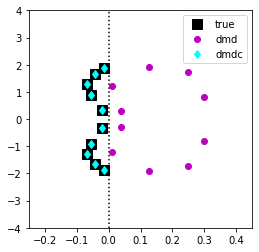

In [11]:
#TODO: dmd yields full stte matrix as Koopman_matrix
Admd = model_dmd.regressor.regressor.atilde
Admdc = model.state_transition_matrix

evals_dmd, evecs_dmd = np.linalg.eig(Admd)
evals_dmd_cont = np.log(evals_dmd)/dt

# evals_dmdc, evecs_dmdc = np.linalg.eig(Admdc)
evals_dmdc_cont = model.eigenvalues_continuous #np.log(evals_dmdc)/dt

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(np.array([0,0]), np.linspace(-4,4,2), ':k')
ax.plot(torus.damping, torus.frequencies, 'sk', label='true', markersize=10)
ax.plot(torus.damping, -torus.frequencies, 'sk', markersize=10)
ax.plot(evals_dmd_cont.real, evals_dmd_cont.imag/(2*np.pi), 'mo', label='dmd')
ax.plot(evals_dmdc_cont.real, evals_dmdc_cont.imag/(2*np.pi), 'd', color='cyan', label='dmdc')
ax.set_xlim(-0.25,0.45)
ax.set_ylim(-4,4)
ax.legend()